# Classification results rendered

Displays all plots and metrics generated in the metrics and visualization stages

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import json
import yaml
from pathlib import Path
from IPython.display import Image

from src import paths

In [3]:

params_path: Path = paths.config_dir("params.yaml")
fault_detection_dir: Path = paths.data_processed_dir("fault_detection")
metrics_dir: Path = paths.reports_dir("metrics")
plots_dir: Path = paths.reports_dir("figures")

with open(params_path, "r") as file:
    params = yaml.safe_load(file)

# Parameters
selected_band: str = params["selected_band"]
selected_score: str = params["parameter_study_max_metric_prefix"]


# Optimal plots

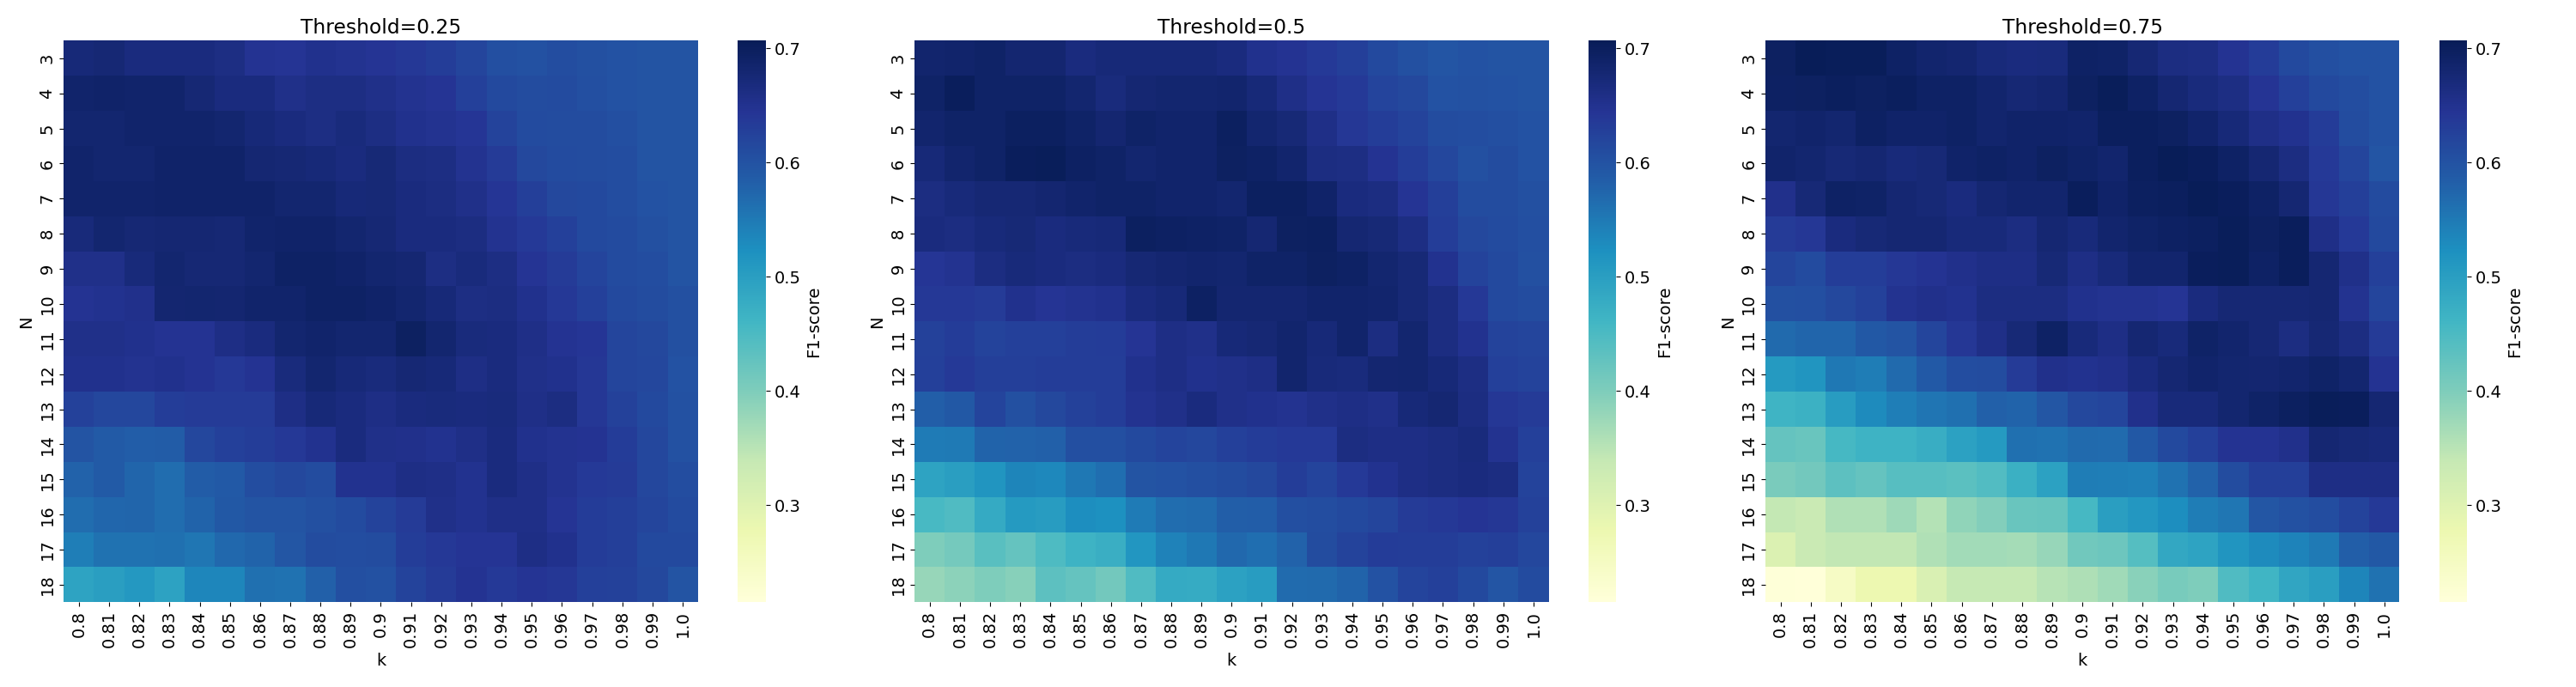

In [4]:
scores_over_params_plot_filename = "_".join([selected_band, selected_score, "over_params"])
scores_over_params_plot_filename += ".png"
scores_over_params_plot_path = plots_dir / scores_over_params_plot_filename

Image(scores_over_params_plot_path)

In [5]:
optimal_model_params_filename = "_".join(
        ["max",
         selected_score,
         "params",
         selected_band])
optimal_model_params_filename += ".json"
optimal_model_params_path = metrics_dir / optimal_model_params_filename

with open(optimal_model_params_path, "r") as file:
    optimal_model_params = json.load(file)

optimal_model_params

{'th': 0.75, 'N': 3, 'k': 0.81}

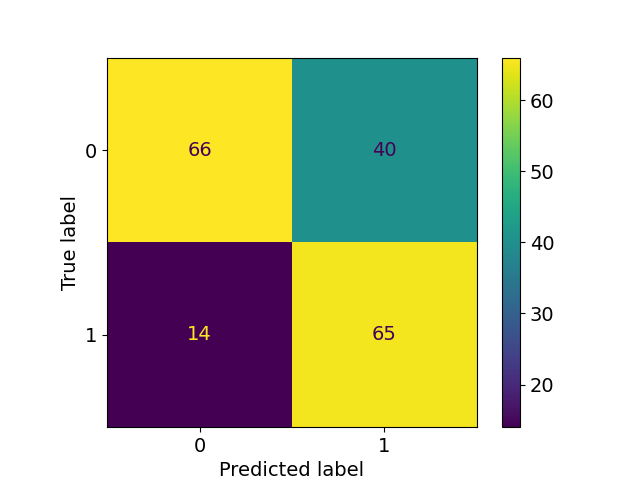

In [6]:
cm_display_filename = "_".join(
        ["max",
         selected_score,
         "cm",
         selected_band])

cm_display_filename += ".png"

cm_display_path = plots_dir / cm_display_filename

Image(cm_display_path)

In [7]:
classification_report_filename = "_".join(
        ["max",
         selected_score,
         "classification_report",
         selected_band]
    )
classification_report_filename += ".csv"
classification_report_path = metrics_dir / classification_report_filename
report_df = pd.read_csv(classification_report_path)

report_df

,Unnamed: 0,precision,recall,f1-score,support
0,0,0.825000,0.622642,0.709677,106.000000
1,1,0.619048,0.822785,0.706522,79.000000
2,accuracy,0.708108,0.708108,0.708108,0.708108
3,macro avg,0.722024,0.722713,0.708100,185.000000
4,weighted avg,0.737053,0.708108,0.708330,185.000000


In [8]:
detailed_cm_percentages_filename = "_".join(
        ["max",
         selected_score,
         "detailed_per_cm", selected_band,
         ]
    )

detailed_cm_percentages_filename += ".csv"
detailed_cm_percentages_path = metrics_dir / detailed_cm_percentages_filename
detailed_cm_precentages = pd.read_csv(detailed_cm_percentages_path)

detailed_cm_precentages

,change_type,label,prediction,proportion
0,logging,1,1.0,0.248649
1,stable,0,0.0,0.227027
2,drought,0,1.0,0.210811
3,drought,0,0.0,0.129730
4,fire,1,1.0,0.102703
5,fire,1,0.0,0.043243
6,logging,1,0.0,0.032432
7,stable,0,1.0,0.005405


In [9]:
detailed_cm_abosolutes_filename = "_".join(
        ["max",
         selected_score,
         "detailed_abs_cm", selected_band,
         ]
    )
detailed_cm_abosolutes_filename += ".csv"
detailed_cm_abosolutes_path = metrics_dir / detailed_cm_abosolutes_filename
detailed_cm_abosolutes = pd.read_csv(detailed_cm_abosolutes_path)

detailed_cm_abosolutes

,change_type,label,prediction,count
0,logging,1,1.0,46
1,stable,0,0.0,42
2,drought,0,1.0,39
3,drought,0,0.0,24
4,fire,1,1.0,19
5,fire,1,0.0,8
6,logging,1,0.0,6
7,stable,0,1.0,1


In [10]:
# TODO: Detection date metrics
non_change_to_detection_filename = "_".join(
        ["max",
         selected_score,
         "non_change_to_detection",
         selected_band]
    )

non_change_to_detection_filename += ".csv"
non_change_to_detection_path = metrics_dir / non_change_to_detection_filename

time_deltas_non_change_to_detection = pd.read_csv(non_change_to_detection_path, index_col="ID")["0"]

time_deltas_non_change_to_detection = pd.to_timedelta(time_deltas_non_change_to_detection)

   

In [12]:
detection_to_change_start_filename = "_".join(
        ["max",
         selected_score,
         "detection_to_change_start",
         selected_band]
    )
detection_to_change_start_filename += ".csv"
detection_to_change_start_path = metrics_dir / detection_to_change_start_filename

time_deltas_detenction_to_change_start = pd.read_csv(
    detection_to_change_start_path, index_col="ID")["0"]

time_deltas_detenction_to_change_start = pd.to_timedelta(time_deltas_detenction_to_change_start)


In [13]:
time_deltas_detenction_to_change_start.describe()

count                           116
mean     31 days 13:14:28.965517241
std      77 days 12:58:57.174363663
min              -26 days +00:00:00
25%              -19 days +00:00:00
50%               -1 days +00:00:00
75%                54 days 00:00:00
max               307 days 00:00:00
Name: 0, dtype: object

In [14]:
# MAE of detection dates

np.sum(np.abs(time_deltas_detenction_to_change_start.to_numpy())).astype(
    'timedelta64[D]') / time_deltas_detenction_to_change_start.shape[0]

numpy.timedelta64(48,'D')

In [15]:
false_positives_detection_dates_filename = "_".join(
        ["max",
         selected_score,
         "false_positives_detection_dates",
         selected_band]
    )
false_positives_detection_dates_filename += ".csv"
false_positives_detection_dates_path = metrics_dir / \
    false_positives_detection_dates_filename

false_positives_detection_dates_description = pd.read_csv(
    false_positives_detection_dates_path, index_col=0)

In [16]:
false_positives_detection_dates_description

,event_date
count,41
mean,2022-10-01 07:36:35.121951232
min,2022-02-27 00:00:00
25%,2022-08-21 00:00:00
50%,2022-10-23 00:00:00
75%,2022-12-04 00:00:00
max,2022-12-11 00:00:00


# Plots by event type

In [17]:
non_change_type = "stable" # stable drought
change_type = "logging" # logging fire

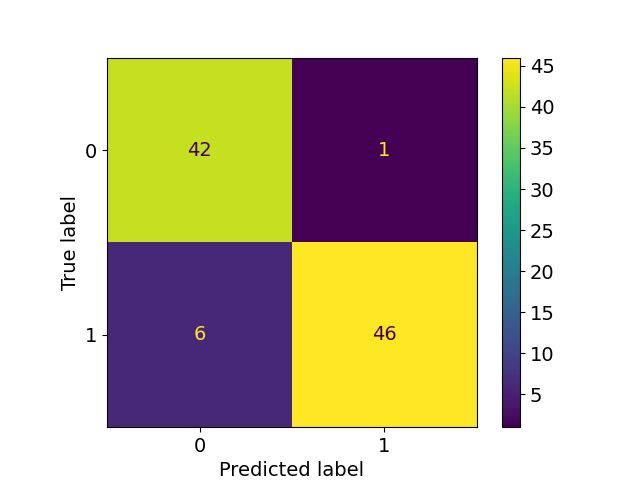

In [18]:
cm_display_filename = "_".join([
            "max",
            selected_score,
            "cm",
            selected_band,
            non_change_type,
            change_type
        ])

cm_display_filename += ".png"

cm_display_path = plots_dir / cm_display_filename

Image(cm_display_path)

In [19]:


classification_report_filename = "_".join([
    "max",
    selected_score,
    "classification_report",
    selected_band,
    non_change_type,
    change_type
])
classification_report_filename += ".csv"
classification_report_path = metrics_dir / classification_report_filename
report_df = pd.read_csv(classification_report_path)

report_df

,Unnamed: 0,precision,recall,f1-score,support
0,0,0.875000,0.976744,0.923077,43.000000
1,1,0.978723,0.884615,0.929293,52.000000
2,accuracy,0.926316,0.926316,0.926316,0.926316
3,macro avg,0.926862,0.930680,0.926185,95.000000
4,weighted avg,0.931775,0.926316,0.926479,95.000000


In [20]:
# TODO: detection date metrics

non_change_to_detection_filename = "_".join(
    ["max",
        selected_score,
        "non_change_to_detection",
        selected_band,
        non_change_type,
        change_type]
)
non_change_to_detection_filename += ".csv"
non_change_to_detection_path = metrics_dir / non_change_to_detection_filename

time_deltas_non_change_to_detection = pd.read_csv(
    non_change_to_detection_path)["0"]

        
time_deltas_non_change_to_detection = pd.to_timedelta(time_deltas_non_change_to_detection)

In [21]:
detection_to_change_start_filename = "_".join(
            ["max",
             selected_score,
             "detection_to_change_start",
             selected_band,
             non_change_type,
             change_type]
        )
detection_to_change_start_filename += ".csv"
detection_to_change_start_path = metrics_dir / detection_to_change_start_filename

time_deltas_detenction_to_change_start = pd.read_csv(detection_to_change_start_path)["0"]

time_deltas_detenction_to_change_start = pd.to_timedelta(time_deltas_detenction_to_change_start)

In [22]:
time_deltas_detenction_to_change_start.describe()

count                             46
mean      58 days 20:52:10.434782609
std      100 days 16:14:29.844208735
min               -25 days +00:00:00
25%               -18 days +06:00:00
50%                  8 days 00:00:00
75%                102 days 12:00:00
max                307 days 00:00:00
Name: 0, dtype: object

In [23]:
# MAE of detection dates

np.sum(np.abs(time_deltas_detenction_to_change_start.to_numpy())).astype(
    'timedelta64[D]') / time_deltas_detenction_to_change_start.shape[0]

numpy.timedelta64(72,'D')

In [24]:

false_positives_detection_dates_filename = "_".join(
    ["max",
        selected_score,
        "false_positives_detection_dates",
        selected_band,
        non_change_type,
        change_type]
)
false_positives_detection_dates_filename += ".csv"
false_positives_detection_dates_path = metrics_dir / \
    false_positives_detection_dates_filename

false_positives_detection_dates_description = pd.read_csv(
    false_positives_detection_dates_path, index_col=0)

In [25]:
false_positives_detection_dates_description

,event_date
count,1
mean,2022-06-12 00:00:00
min,2022-06-12 00:00:00
25%,2022-06-12 00:00:00
50%,2022-06-12 00:00:00
75%,2022-06-12 00:00:00
max,2022-06-12 00:00:00
